In [1]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, pearsonr

import seaborn as sns

from basenji.gene import gtf_kv
from basenji import gene as bgene

from sklearn.metrics import average_precision_score, roc_auc_score

#Function require that a crispr row exists in both dataframes, or that it is beyond a certain distance from TSS
def intersect_or_beyond(crispr_df_1, crispr_df_2, distance_within=0) :
    
    #Get natural keys
    crispr_df_1['join_id'] = crispr_df_1['chr'] + '_' + crispr_df_1['start'].astype(str) + '_' + crispr_df_1['end'].astype(str) + '_' + crispr_df_1['gene'].astype(str)
    crispr_df_2['join_id'] = crispr_df_2['chr'] + '_' + crispr_df_2['start'].astype(str) + '_' + crispr_df_2['end'].astype(str) + '_' + crispr_df_2['gene'].astype(str)
    
    #Filter dataframe copies
    crispr_df_1_copy = crispr_df_1.loc[(crispr_df_1['tss_distance'] > distance_within) | (crispr_df_1['join_id'].isin(crispr_df_2['join_id'].values.tolist()))].copy()
    crispr_df_2_copy = crispr_df_2.loc[(crispr_df_2['tss_distance'] > distance_within) | (crispr_df_2['join_id'].isin(crispr_df_1['join_id'].values.tolist()))].copy()
    
    return crispr_df_1_copy, crispr_df_2_copy

#Function to compute accuracy stats for crispr benchmark
def accuracy_stats(crispr_df, n_bootstrap=1000, lo=0.025, hi=0.975, distance_boundaries=[0, 15000, 60000, 130000, 262144]) :
  
    col_names = ['dist', 'sites', 'pos', 'auc', 'ap', 'tss_auc', 'tss_ap', 'auc_lo', 'auc_med', 'auc_hi', 'ap_lo', 'ap_med', 'ap_hi']
    print('\t'.join(col_names))
    
    lines = []
    
    #Loop over distance boundaries
    for di in range(len(distance_boundaries) - 1) :
        
        #Apply distance filter
        distance_mask = (crispr_df.tss_distance > distance_boundaries[di])
        distance_mask &= (crispr_df.tss_distance <= distance_boundaries[di+1])
        dcrispr_df = crispr_df[distance_mask]

        #Get number of sites
        num_sites = dcrispr_df.shape[0]
        num_pos = dcrispr_df.regulate.sum()

        #Compute accuracies
        if num_sites < 2 or num_pos < 1 :
            auroc_model = np.nan
            auprc_model = np.nan
            auroc_tss = np.nan
            auprc_tss = np.nan

        else :
            auroc_model = roc_auc_score(dcrispr_df.regulate, dcrispr_df.score)
            auprc_model = average_precision_score(dcrispr_df.regulate, dcrispr_df.score)
            auroc_tss = roc_auc_score(dcrispr_df.regulate, 1./dcrispr_df.tss_distance)
            auprc_tss = average_precision_score(dcrispr_df.regulate, 1./dcrispr_df.tss_distance)
        
        #Estimate confidence interval by bootstrapping
        auroc_model_bootstrap = []
        auprc_model_bootstrap = []
        if n_bootstrap > 0 :
            
            #Loop over bootstrap samples
            for sample_ix in range(n_bootstrap) :
                
                #Resample data with replacement
                bootstrap_index = np.random.choice(np.arange(len(dcrispr_df)).tolist(), size=(len(dcrispr_df),), replace=True).tolist()
                dcrispr_df_bootstrap = dcrispr_df.iloc[bootstrap_index].copy()
                
                #Get number of sites
                num_sites_bootstrap = dcrispr_df_bootstrap.shape[0]
                num_pos_bootstrap = dcrispr_df_bootstrap.regulate.sum()

                #Compute accuracies
                if num_sites_bootstrap < 2 or num_pos_bootstrap < 1 :
                    auroc_model_bootstrap.append(np.nan)
                    auprc_model_bootstrap.append(np.nan)
                else :
                    auroc_model_bootstrap.append(roc_auc_score(dcrispr_df_bootstrap.regulate, dcrispr_df_bootstrap.score))
                    auprc_model_bootstrap.append(average_precision_score(dcrispr_df_bootstrap.regulate, dcrispr_df_bootstrap.score))
        
        auroc_model_lo = np.nan
        auroc_model_med = np.nan
        auroc_model_hi = np.nan
        auprc_model_lo = np.nan
        auprc_model_med = np.nan
        auprc_model_hi = np.nan
        if n_bootstrap > 0 :
            auroc_model_lo = np.quantile(auroc_model_bootstrap, q=lo)
            auroc_model_med = np.median(auroc_model_bootstrap)
            auroc_model_hi = np.quantile(auroc_model_bootstrap, q=hi)
            auprc_model_lo = np.quantile(auprc_model_bootstrap, q=lo)
            auprc_model_med = np.median(auprc_model_bootstrap)
            auprc_model_hi = np.quantile(auprc_model_bootstrap, q=hi)
        
        #Print accuracies
        cols = [str(distance_boundaries[di+1]), str(num_sites), str(num_pos)]
        cols += ['%.4f' % auroc_model, '%.4f' % auprc_model]
        cols += ['%.4f' % auroc_tss, '%.4f' % auprc_tss]
        cols += ['%.4f' % auroc_model_lo, '%.4f' % auroc_model_med, '%.4f' % auroc_model_hi]
        cols += ['%.4f' % auprc_model_lo, '%.4f' % auprc_model_med, '%.4f' % auprc_model_hi]
        
        lines.append('\t'.join(cols))
        
        print(lines[-1])
    
    #Create dataframe with stats
    stats_df = pd.DataFrame([li.split('\t') for li in lines], columns=col_names)
    
    return stats_df

#Function to compute fold change stats for crispr benchmark
def fc_stats(crispr_df, n_bootstrap=1000, lo=0.025, hi=0.975, distance_boundaries=[0, 15000, 60000, 130000, 262144]) :
  
    col_names = ['dist', 'sites', 'pos', 'fc', 'fc_lo', 'fc_med', 'fc_hi']
    print('\t'.join(col_names))
    
    lines = []
    
    #Loop over distance boundaries
    for di in range(len(distance_boundaries) - 1) :
        
        #Apply distance filter
        distance_mask = (crispr_df.tss_distance > distance_boundaries[di])
        distance_mask &= (crispr_df.tss_distance <= distance_boundaries[di+1])
        dcrispr_df = crispr_df[distance_mask]

        #Get number of sites
        num_sites = dcrispr_df.shape[0]
        num_pos = dcrispr_df.regulate.sum()

        #Compute accuracies
        if num_sites < 2 or num_pos < 1 :
            fc_model = np.nan
        else :
            fc_model = dcrispr_df.query("regulate == True")['pct_change'].abs().mean() / dcrispr_df.query("regulate == False")['pct_change'].abs().mean()
        
        #Estimate confidence interval by bootstrapping
        fc_model_bootstrap = []
        if n_bootstrap > 0 :
            
            #Loop over bootstrap samples
            for sample_ix in range(n_bootstrap) :
                
                #Resample data with replacement
                bootstrap_index = np.random.choice(np.arange(len(dcrispr_df)).tolist(), size=(len(dcrispr_df),), replace=True).tolist()
                dcrispr_df_bootstrap = dcrispr_df.iloc[bootstrap_index].copy()
                
                #Get number of sites
                num_sites_bootstrap = dcrispr_df_bootstrap.shape[0]
                num_pos_bootstrap = dcrispr_df_bootstrap.regulate.sum()

                #Compute accuracies
                if num_sites_bootstrap < 2 or num_pos_bootstrap < 1 :
                    fc_model_bootstrap.append(np.nan)
                else :
                    fc_model_bootstrap.append(dcrispr_df_bootstrap.query("regulate == True")['pct_change'].abs().mean() / dcrispr_df_bootstrap.query("regulate == False")['pct_change'].abs().mean())
        
        fc_model_lo = np.nan
        fc_model_med = np.nan
        fc_model_hi = np.nan
        if n_bootstrap > 0 :
            fc_model_lo = np.quantile(fc_model_bootstrap, q=lo)
            fc_model_med = np.median(fc_model_bootstrap)
            fc_model_hi = np.quantile(fc_model_bootstrap, q=hi)
        
        #Print accuracies
        cols = [str(distance_boundaries[di+1]), str(num_sites), str(num_pos)]
        cols += ['%.4f' % fc_model]
        cols += ['%.4f' % fc_model_lo, '%.4f' % fc_model_med, '%.4f' % fc_model_hi]
        
        lines.append('\t'.join(cols))
        
        print(lines[-1])
    
    #Create dataframe with stats
    stats_df = pd.DataFrame([li.split('\t') for li in lines], columns=col_names)
    
    return stats_df

#Function to plot barchart with model performance 
def plot_bars(model_names, model_dfs, model_colors, limit_x=False, legend_outside=False, model_hatches=None, fig_size=(8, 3), plot_title='FlowFISH - Gradients (gaussian)', metric='ap', metric_str='AUPRC', distances=[15000, 60000, 130000, 262000], distance_strs=['< 15kb', '15kb - 60kb', '60kb - 130kb', '130kb - 262kb'], y_min=0.0, y_max=1.0, save_name=None) : 
    
    n_models = len(model_names)
    n_distances = len(distances)

    f = plt.figure(figsize=fig_size, dpi=300)

    distances_x = np.arange(len(distances))

    #Loop over models
    for model_i in range(n_models) :

        #Plot metrics
        acc_val = np.array(model_dfs[model_i][metric].astype('float32').values, dtype='float32')
        acc_lo = np.array(model_dfs[model_i][metric + '_lo'].astype('float32').values, dtype='float32')
        acc_hi = np.array(model_dfs[model_i][metric + '_hi'].astype('float32').values, dtype='float32')

        hatch = None if model_hatches is None else model_hatches[model_i]
        
        plt.bar(distances_x * (n_models + 0.5) + model_i, acc_val, width=0.8, color=model_colors[model_i], hatch=hatch, label=model_names[model_i], edgecolor='black', linewidth=0.5)

        #Plot bootstrap confidence interval
        for distance_i in range(n_distances) :
            if acc_lo[distance_i] != acc_val[distance_i] and acc_hi[distance_i] != acc_val[distance_i] :

                x_mid = (distances_x * (n_models + 0.5) + model_i)[distance_i]
                acc_lo_val = acc_lo[distance_i]
                acc_hi_val = acc_hi[distance_i]

                plt.plot([x_mid - 0.35, x_mid + 0.35], [acc_lo_val, acc_lo_val], linewidth=0.5, linestyle='-', color='red')
                plt.plot([x_mid, x_mid], [acc_lo_val, acc_hi_val], linewidth=0.5, linestyle='--', color='red')
                plt.plot([x_mid - 0.35, x_mid + 0.35], [acc_hi_val, acc_hi_val], linewidth=0.5, linestyle='-', color='red')

    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)

    if limit_x :
        plt.xlim(-1.5, len(distances) * (n_models + 0.5))
    
    plt.xticks(distances_x * (n_models + 0.5) + n_models / 2. - 0.5, distance_strs, fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.ylabel(metric_str, fontsize=10)

    if not legend_outside :
        plt.legend(fontsize=8)
    else :
        plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=3)

    plt.title(plot_title, fontsize=10)

    plt.tight_layout()
    
    if save_name is not None :
        plt.savefig(save_name + '.eps')

    plt.show()


In [2]:
#Load dataframes

#Borzoi ism shuffles
crispr_df_borzoi_ensemble_ism = pd.read_csv("site_scores_flowfish_k562_ism_borzoi_ensemble.csv", sep='\t')
crispr_df_borzoi_ensemble_ism_narrow = pd.read_csv("site_scores_flowfish_k562_ism_borzoi_ensemble_narrow.csv", sep='\t')
crispr_df_borzoi_ensemble_ism_less_narrow = pd.read_csv("site_scores_flowfish_k562_ism_borzoi_ensemble_less_narrow.csv", sep='\t')
crispr_df_borzoi_ensemble_ism_wide = pd.read_csv("site_scores_flowfish_k562_ism_borzoi_ensemble_wide.csv", sep='\t')

#Enformer ism shuffles
crispr_df_enformer_ism = pd.read_csv("site_scores_flowfish_k562_ism_enformer2.csv", sep='\t')
crispr_df_enformer_ism_narrow = pd.read_csv("site_scores_flowfish_k562_ism_enformer2_narrow.csv", sep='\t')
crispr_df_enformer_ism_less_narrow = pd.read_csv("site_scores_flowfish_k562_ism_enformer2_less_narrow.csv", sep='\t')
crispr_df_enformer_ism_wide = pd.read_csv("site_scores_flowfish_k562_ism_enformer2_wide.csv", sep='\t')

#Apply intersections and filter crispr rows

distance_within = 98000

#ISM Shuffle
crispr_df_borzoi_ensemble_ism, crispr_df_enformer_ism = intersect_or_beyond(crispr_df_borzoi_ensemble_ism, crispr_df_enformer_ism, distance_within=distance_within)
crispr_df_borzoi_ensemble_ism_narrow, crispr_df_enformer_ism = intersect_or_beyond(crispr_df_borzoi_ensemble_ism_narrow, crispr_df_enformer_ism, distance_within=distance_within)
crispr_df_borzoi_ensemble_ism_less_narrow, crispr_df_enformer_ism = intersect_or_beyond(crispr_df_borzoi_ensemble_ism_less_narrow, crispr_df_enformer_ism, distance_within=distance_within)
crispr_df_borzoi_ensemble_ism_wide, crispr_df_enformer_ism = intersect_or_beyond(crispr_df_borzoi_ensemble_ism_wide, crispr_df_enformer_ism, distance_within=distance_within)

_, crispr_df_enformer_ism_narrow = intersect_or_beyond(crispr_df_borzoi_ensemble_ism, crispr_df_enformer_ism_narrow, distance_within=distance_within)
_, crispr_df_enformer_ism_less_narrow = intersect_or_beyond(crispr_df_borzoi_ensemble_ism, crispr_df_enformer_ism_less_narrow, distance_within=distance_within)
_, crispr_df_enformer_ism_wide = intersect_or_beyond(crispr_df_borzoi_ensemble_ism, crispr_df_enformer_ism_wide, distance_within=distance_within)


In [3]:
#Evaluate borzoi scores (ism shuffle; extra configurations)

print("-- borzoi scores (ism shuffle; ensemble; narrow) --")

#Compute and print accuracy stats
stats_df_borzoi_ism_narrow = accuracy_stats(
    crispr_df_borzoi_ensemble_ism_narrow,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("-- borzoi scores (ism shuffle; ensemble; less narrow) --")

#Compute and print accuracy stats
stats_df_borzoi_ism_less_narrow = accuracy_stats(
    crispr_df_borzoi_ensemble_ism_less_narrow,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("-- borzoi scores (ism shuffle; ensemble) --")

#Compute and print accuracy stats
stats_df_borzoi_ism = accuracy_stats(
    crispr_df_borzoi_ensemble_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("-- borzoi scores (ism shuffle; ensemble; wide) --")

#Compute and print accuracy stats
stats_df_borzoi_ism_wide = accuracy_stats(
    crispr_df_borzoi_ensemble_ism_wide,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)


-- borzoi scores (ism shuffle; ensemble; narrow) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	144	47	0.7212	0.6425	0.7594	0.5610	0.6245	0.7254	0.8077	0.5170	0.6500	0.7590
45000	277	43	0.7170	0.5785	0.6591	0.2351	0.6135	0.7156	0.8199	0.4409	0.5840	0.7204
98000	500	14	0.6351	0.2573	0.4974	0.0402	0.4357	0.6359	0.8206	0.0494	0.2587	0.4811
262144	1220	12	0.7653	0.2515	0.4259	0.0096	0.6112	0.7727	0.8905	0.0218	0.2491	0.5306
-- borzoi scores (ism shuffle; ensemble; less narrow) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	144	47	0.7142	0.6308	0.7594	0.5610	0.6148	0.7149	0.7972	0.5093	0.6374	0.7506
45000	277	43	0.7760	0.5926	0.6591	0.2351	0.6750	0.7762	0.8626	0.4506	0.5985	0.7232
98000	500	14	0.6902	0.1949	0.4974	0.0402	0.5128	0.6850	0.8433	0.0393	0.1992	0.4104
262144	1220	12	0.7617	0.2895	0.4259	0.0096	0.6130	0.7641	0.8906	0.0385	0.2885	0.5585
-- borzoi scores (ism shuffle; ensemble) --
dist	sites	pos	auc	ap	t

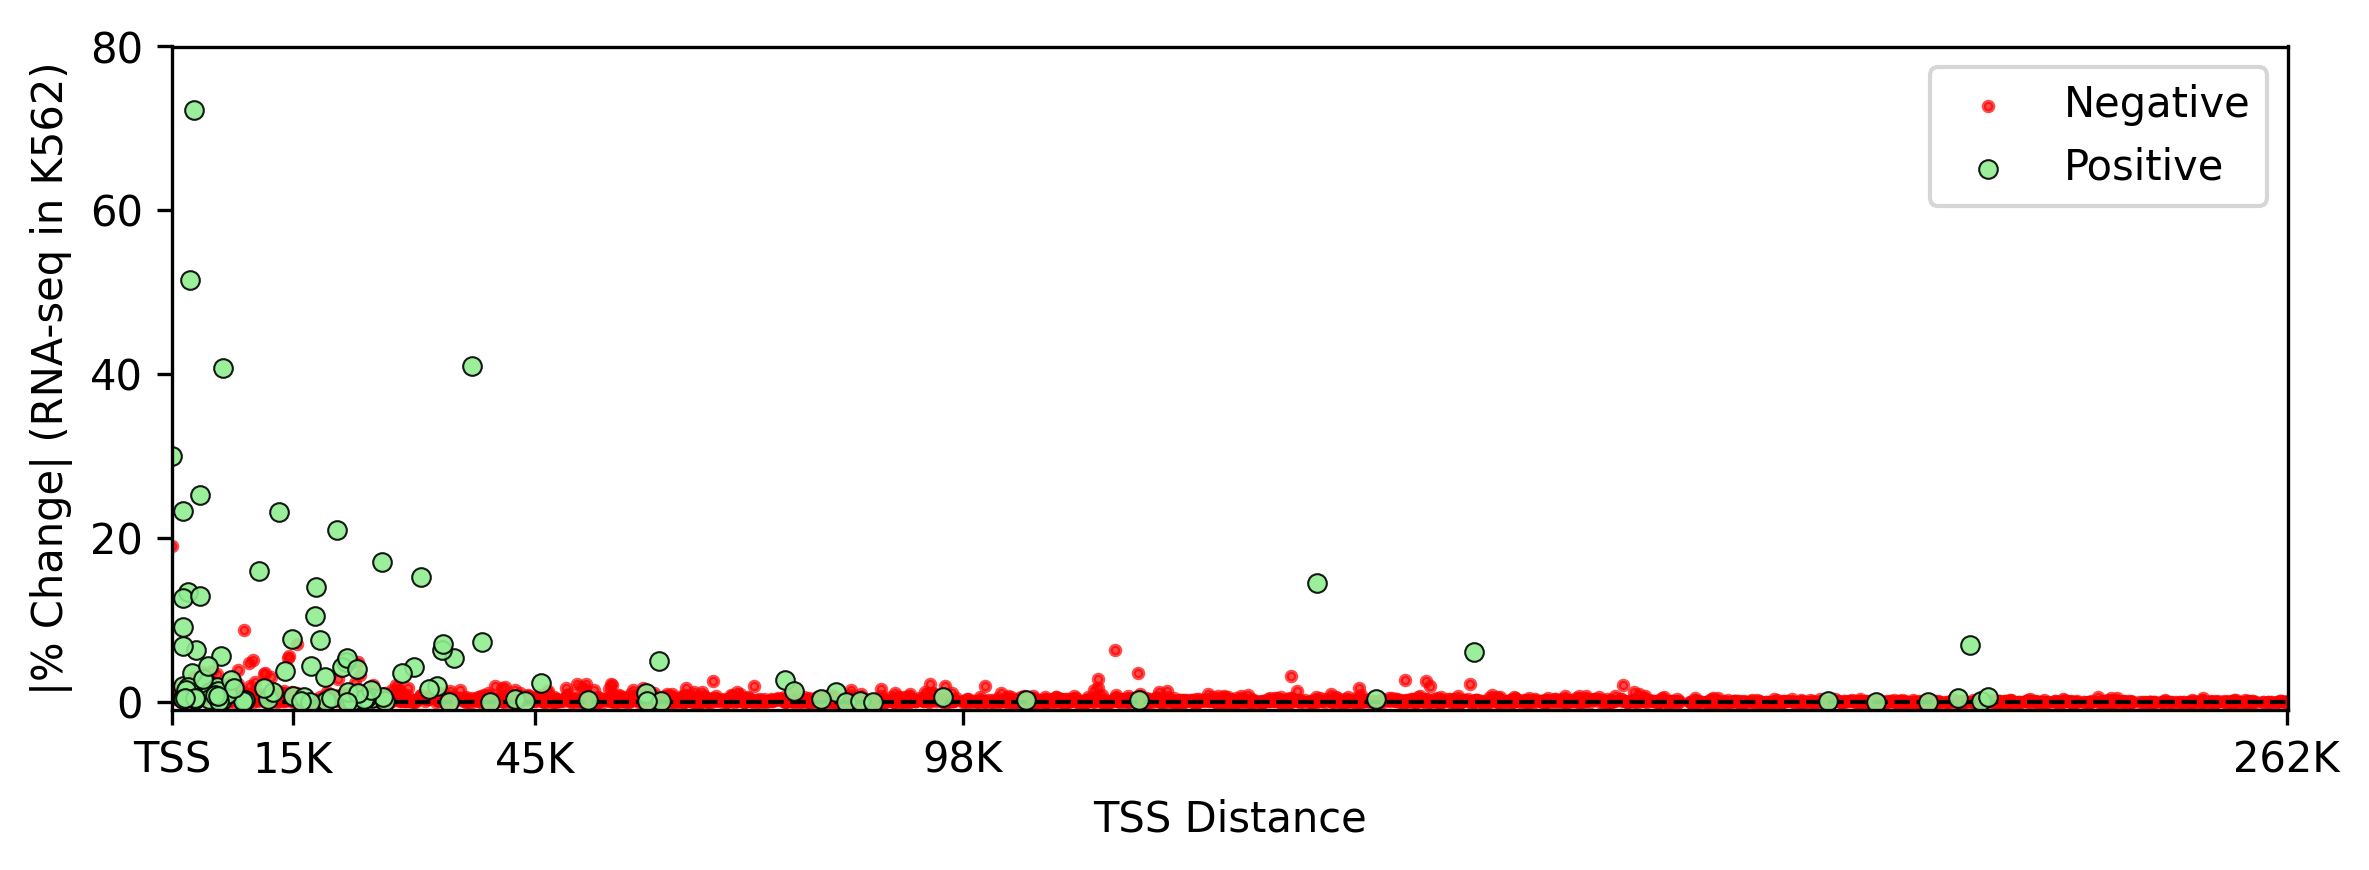

In [4]:
#Plot distribution of predictions for positives and negatives (narrow)
crispr_df = crispr_df_borzoi_ensemble_ism_narrow

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 262144)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 262000], ['TSS', '15K', '45K', '98K', '262K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


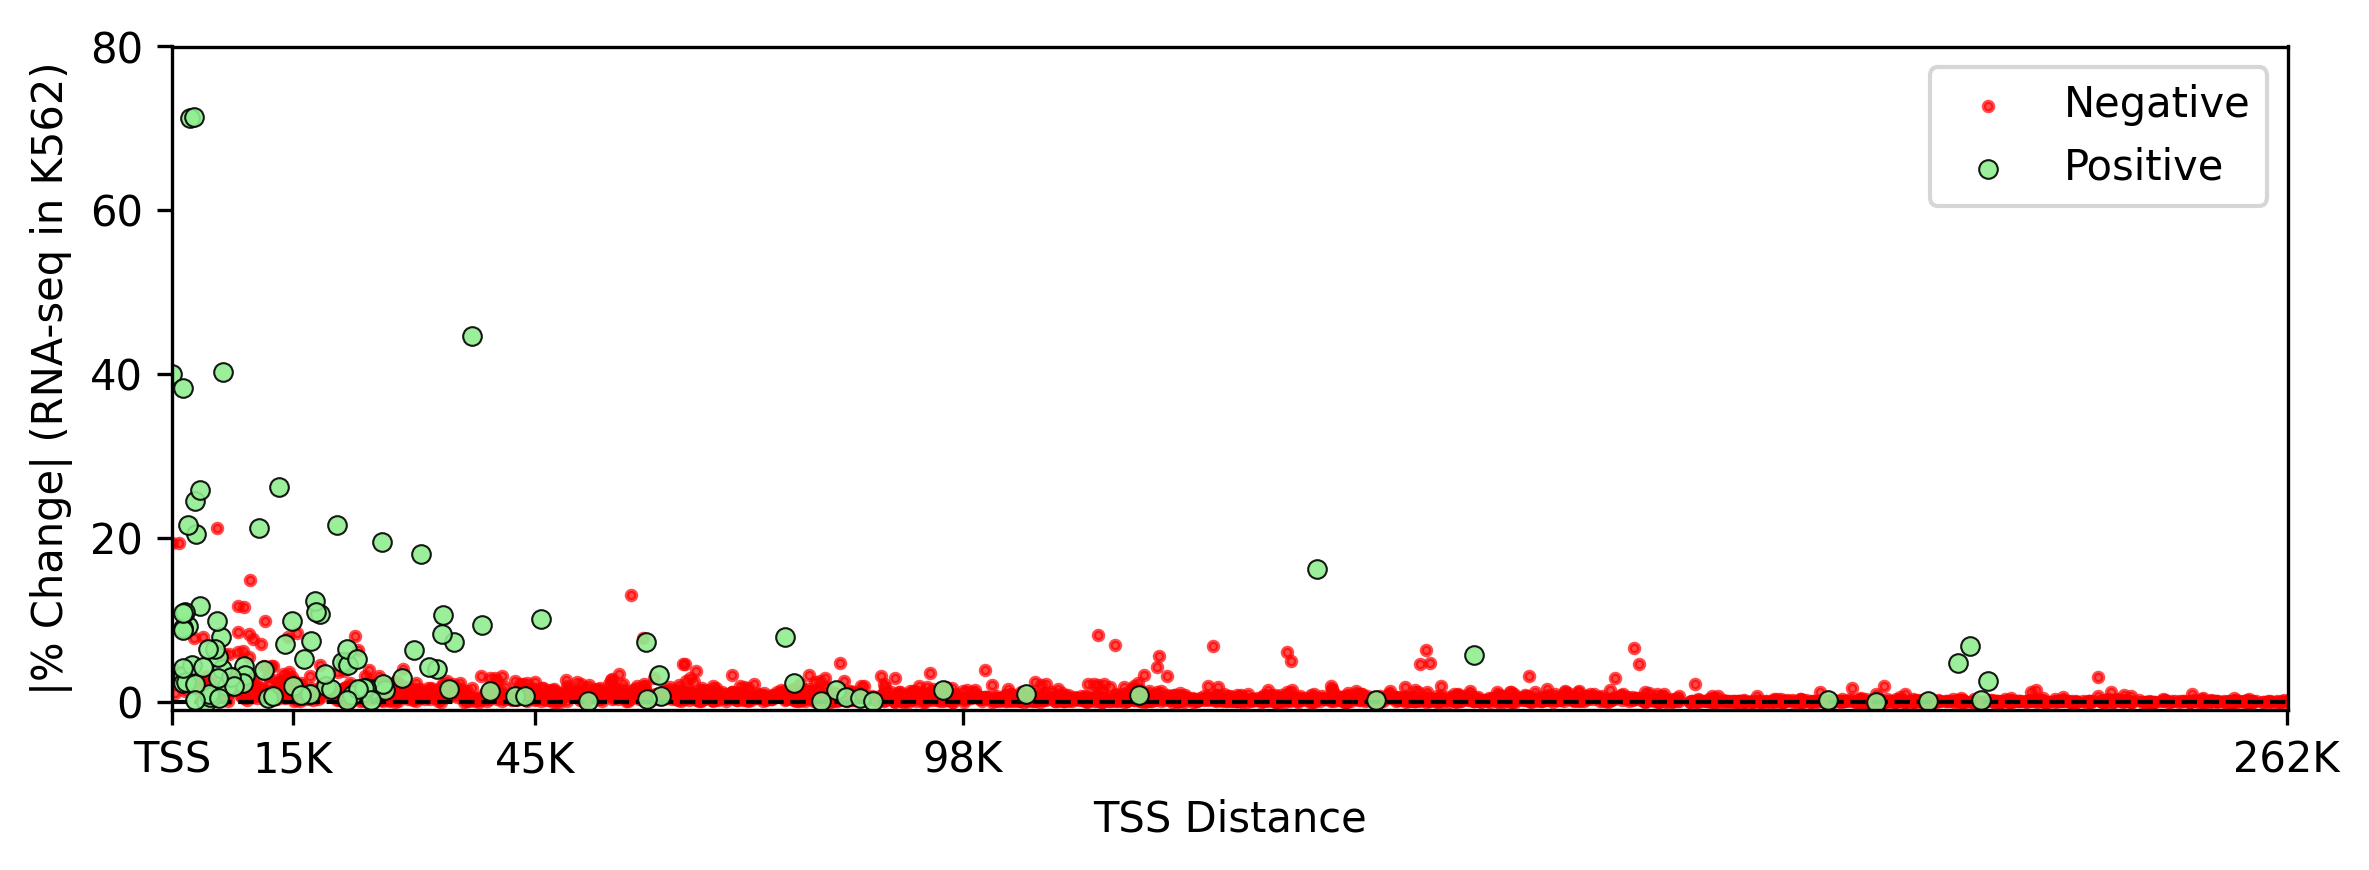

In [5]:
#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_borzoi_ensemble_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 262144)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 262000], ['TSS', '15K', '45K', '98K', '262K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


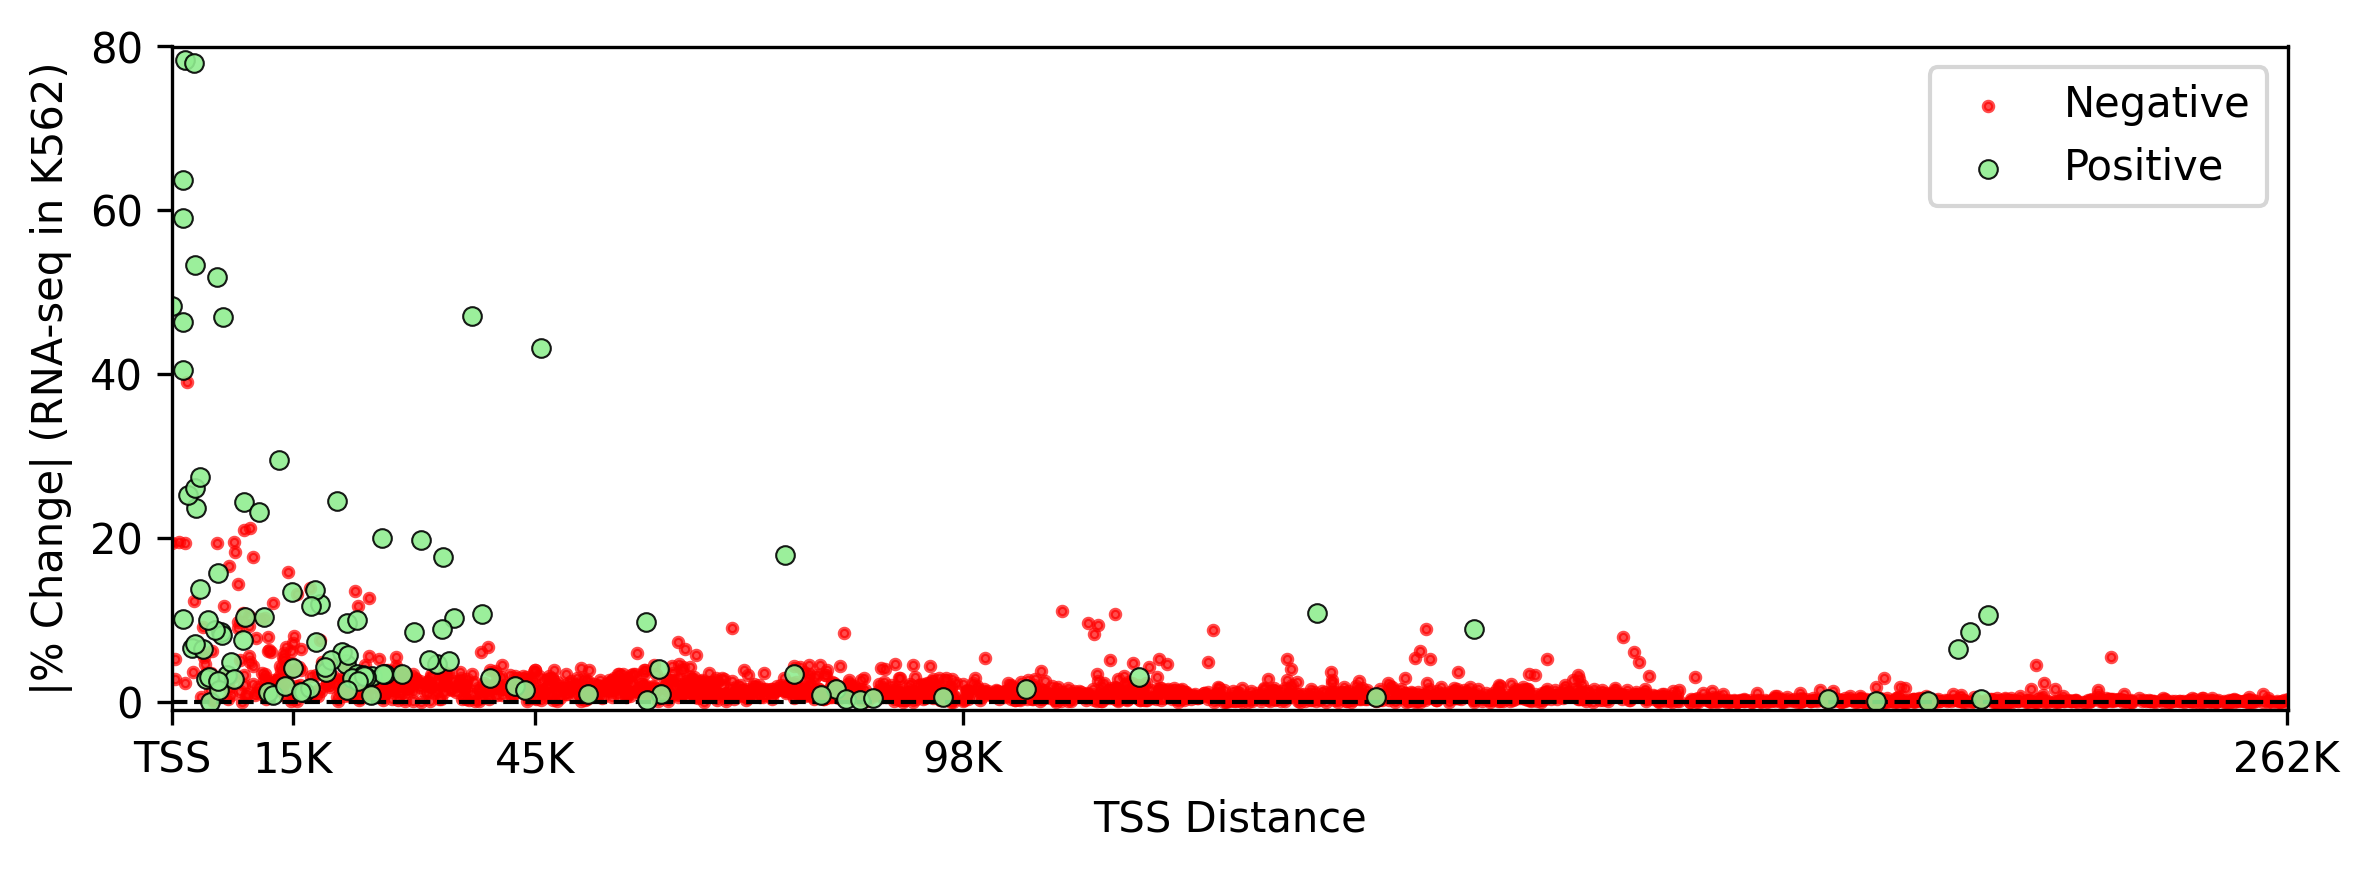

In [6]:
#Plot distribution of predictions for positives and negatives (wide)
crispr_df = crispr_df_borzoi_ensemble_ism_wide

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 262144)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 262000], ['TSS', '15K', '45K', '98K', '262K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


In [7]:
#Evaluate enformer scores (ism shuffle; extra configurations)

print("-- enformer scores (ism shuffle; ensemble; narrow) --")

#Compute and print accuracy stats
stats_df_enformer_ism_narrow = accuracy_stats(
    crispr_df_enformer_ism_narrow,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("-- enformer scores (ism shuffle; ensemble; less narrow) --")

#Compute and print accuracy stats
stats_df_enformer_ism_less_narrow = accuracy_stats(
    crispr_df_enformer_ism_less_narrow,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("-- enformer scores (ism shuffle; ensemble) --")

#Compute and print accuracy stats
stats_df_enformer_ism = accuracy_stats(
    crispr_df_enformer_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)

print("-- enformer scores (ism shuffle; ensemble; wide) --")

#Compute and print accuracy stats
stats_df_enformer_ism_wide = accuracy_stats(
    crispr_df_enformer_ism_wide,
    distance_boundaries=[0, 15000, 45000, 98000, 262144],
)


-- enformer scores (ism shuffle; ensemble; narrow) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	144	47	0.7967	0.6429	0.7594	0.5610	0.7139	0.7962	0.8770	0.5065	0.6562	0.7998
45000	277	43	0.6344	0.3952	0.6591	0.2351	0.5278	0.6381	0.7349	0.2630	0.4051	0.5447
98000	500	14	0.5046	0.1102	0.4974	0.0402	0.3331	0.4991	0.6755	0.0181	0.1063	0.2902
262144	0	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
-- enformer scores (ism shuffle; ensemble; less narrow) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	144	47	0.7648	0.5870	0.7594	0.5610	0.6706	0.7670	0.8477	0.4549	0.6023	0.7517
45000	277	43	0.6291	0.3808	0.6591	0.2351	0.5123	0.6310	0.7272	0.2435	0.3897	0.5268
98000	500	14	0.4064	0.0480	0.4974	0.0402	0.2352	0.4004	0.5841	0.0146	0.0480	0.1946
262144	0	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
-- enformer scores (ism shuffle; ensemble) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1

In [8]:
#Create stats dataframes for TSS baseline (no bootstrapping)

#Standard baseline
stats_df_tss = stats_df_borzoi_ism[['dist', 'sites', 'pos', 'tss_auc', 'tss_ap']].copy()

stats_df_tss['auc'] = stats_df_tss['tss_auc']
stats_df_tss['ap'] = stats_df_tss['tss_ap']
stats_df_tss['auc_lo'] = stats_df_tss['auc']
stats_df_tss['auc_med'] = stats_df_tss['auc']
stats_df_tss['auc_hi'] = stats_df_tss['auc']
stats_df_tss['ap_lo'] = stats_df_tss['ap']
stats_df_tss['ap_med'] = stats_df_tss['ap']
stats_df_tss['ap_hi'] = stats_df_tss['ap']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


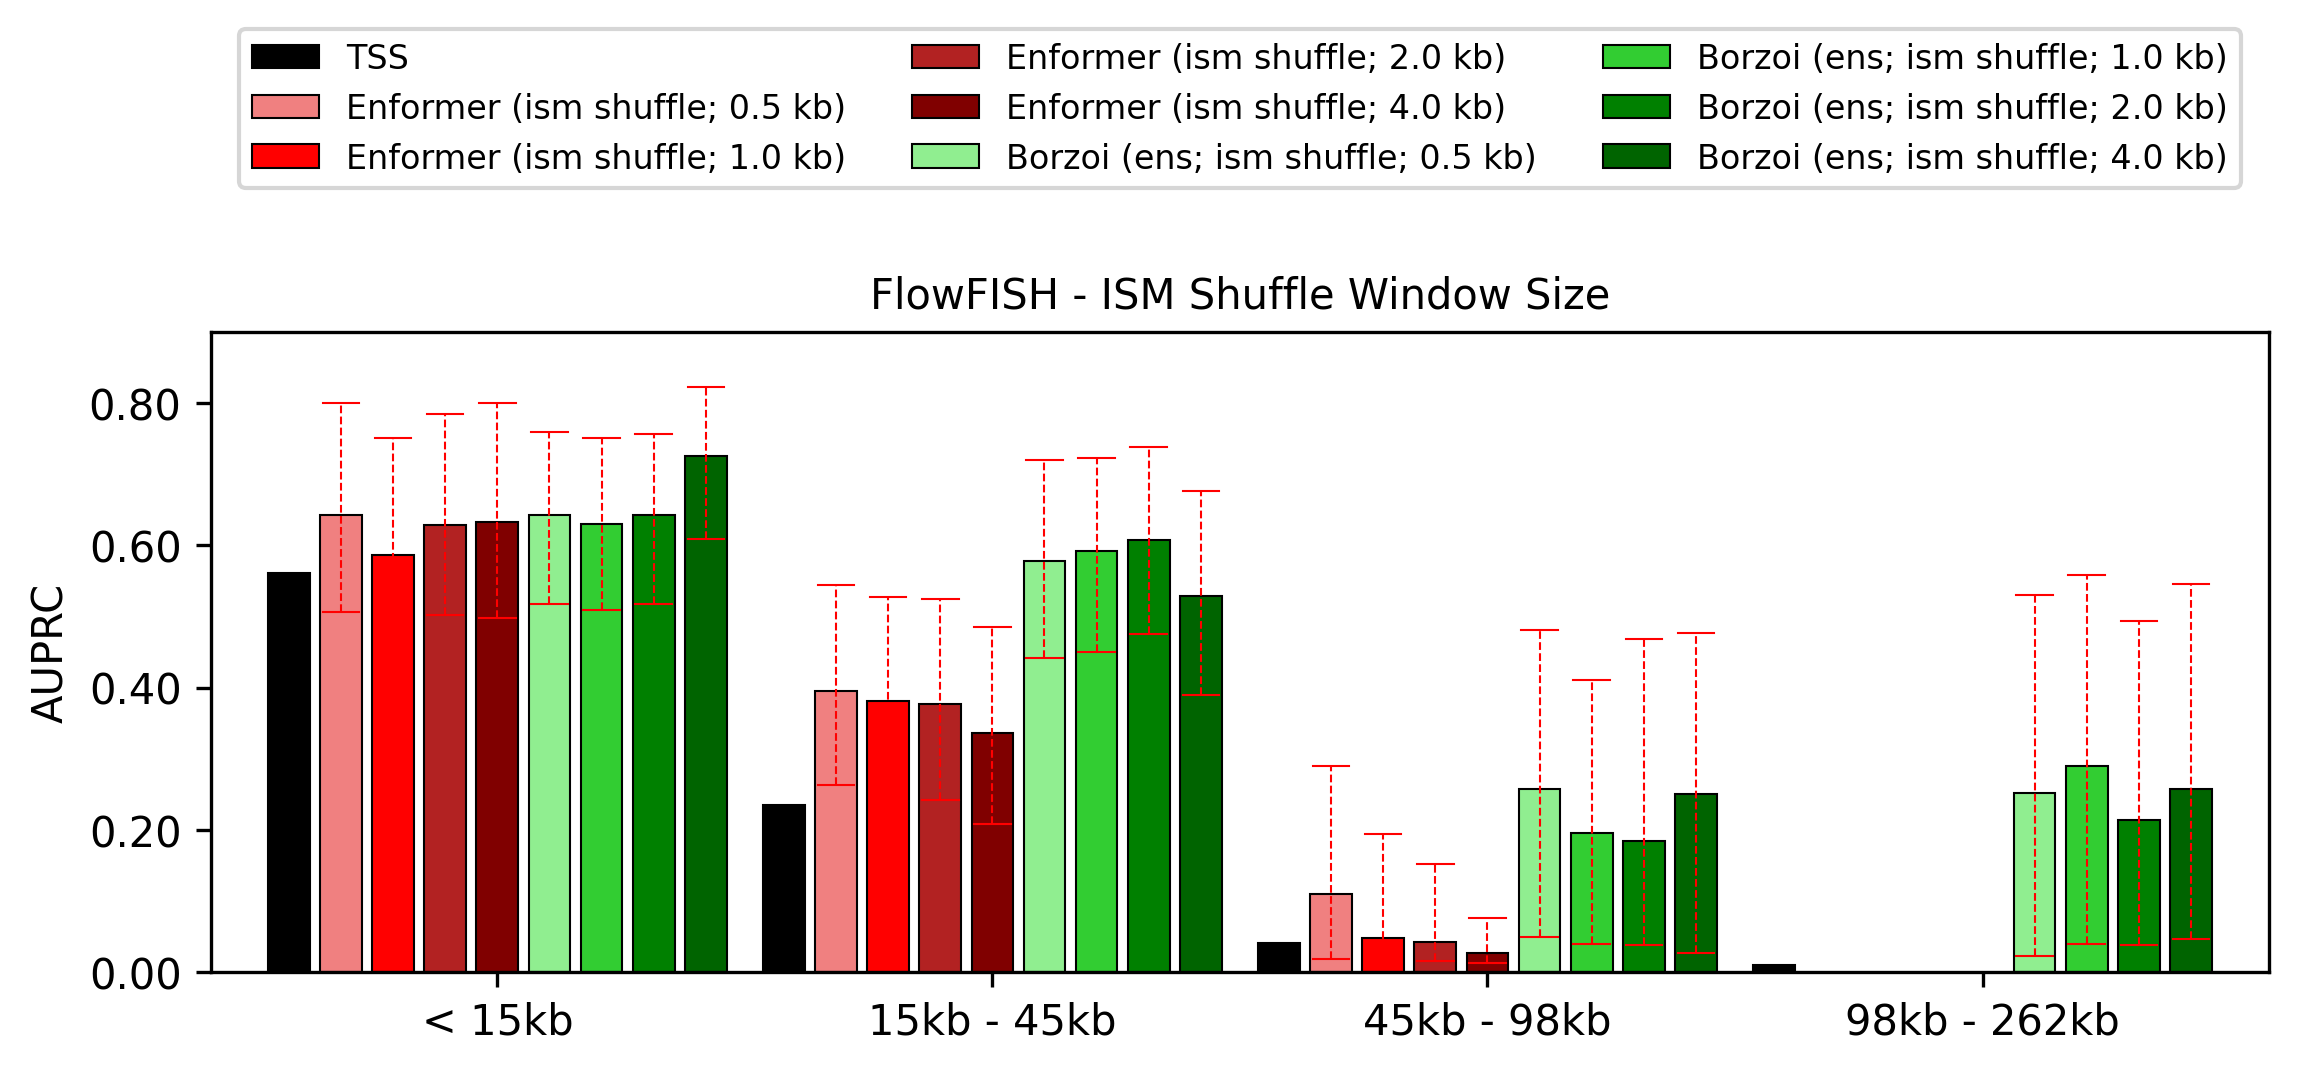

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


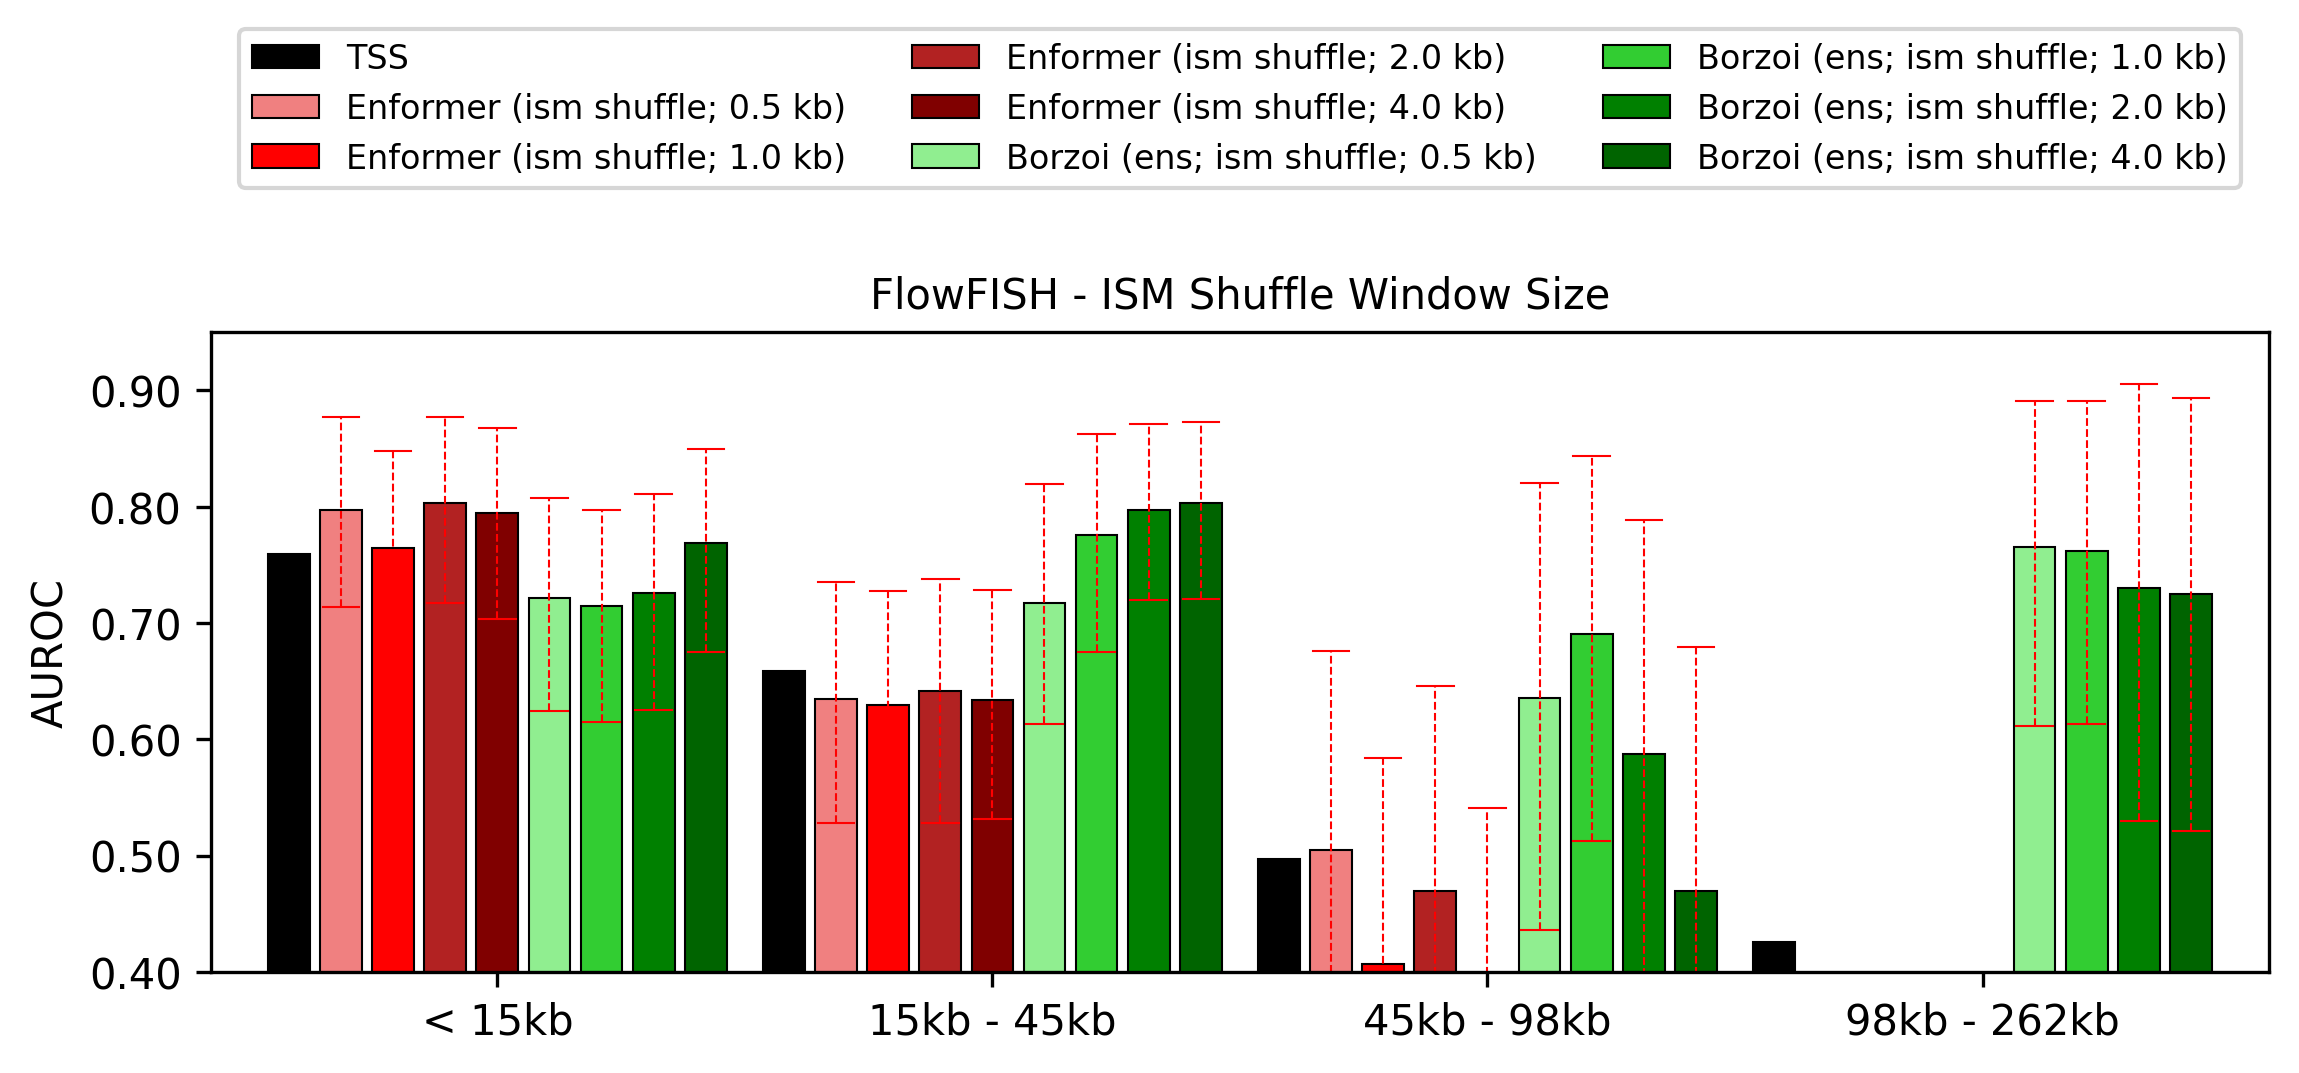

In [9]:
#Plot AUPRC bar chart with perfomance metrics (ISM; extra comparisons)

#Model names
model_names = [
    'TSS',
    'Enformer (ism shuffle; 0.5 kb)',
    'Enformer (ism shuffle; 1.0 kb)',
    'Enformer (ism shuffle; 2.0 kb)',
    'Enformer (ism shuffle; 4.0 kb)',
    'Borzoi (ens; ism shuffle; 0.5 kb)',
    'Borzoi (ens; ism shuffle; 1.0 kb)',
    'Borzoi (ens; ism shuffle; 2.0 kb)',
    'Borzoi (ens; ism shuffle; 4.0 kb)',
]

#Stats dataframes
model_dfs = [
    stats_df_tss,
    stats_df_enformer_ism_narrow,
    stats_df_enformer_ism_less_narrow,
    stats_df_enformer_ism,
    stats_df_enformer_ism_wide,
    stats_df_borzoi_ism_narrow,
    stats_df_borzoi_ism_less_narrow,
    stats_df_borzoi_ism,
    stats_df_borzoi_ism_wide,
]

#Model colors
model_colors = [
    'black',
    'lightcoral',
    'red',
    'firebrick',
    'maroon',
    'lightgreen',
    'limegreen',
    'green',
    'darkgreen',
]

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='FlowFISH - ISM Shuffle Window Size',
    metric='ap',
    metric_str='AUPRC',
    distances=[15000, 45000, 98000, 262000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 262kb'],
    y_min=0.0,
    y_max=0.9,
    save_name='flowfish_ism_bench_prc'
)

#Plot AUROC bar chart

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='FlowFISH - ISM Shuffle Window Size',
    metric='auc',
    metric_str='AUROC',
    distances=[15000, 45000, 98000, 262000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 262kb'],
    y_min=0.4,
    y_max=0.95,
    save_name='flowfish_ism_bench_roc'
)
